In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pickle

import datetime
import pandas as pd
import numpy as np
import timeit
from matplotlib import pyplot as plt
pd.set_option("display.max_columns", 500)

In [2]:
train_df = pd.read_csv("D:\\DataSets\\airbnb\\train_users_2.csv", header=0, index_col=None)
test_df = pd.read_csv("D:\\DataSets\\airbnb\\test_users.csv", header=0, index_col=None)
sessions = pd.read_csv("D:\\DataSets\\airbnb\\sessions.csv", header=0, index_col=False)

In [3]:
df_all = pd.concat((train_df, test_df), axis=0, ignore_index=True)

# Cleaning Data

By closely inspecting the data in table we can fish out abnormalities, outliers, or redundant information.

In [4]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


#### Already by just looking at the first five rows we can observe the following:

1) Date format is not consistant in columns 'date_account_created', 'timestamp_first_active', 'date_first_booking'. We can convert them all into timestamp format.

2) Gender column has 'unknown' values for some rows and age column consists of NaN values.

Let's check which columns have NaN values:

In [5]:
df_all.isna().sum()

affiliate_channel               0
affiliate_provider              0
age                        116866
country_destination         62096
date_account_created            0
date_first_booking         186639
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
signup_app                      0
signup_flow                     0
signup_method                   0
timestamp_first_active          0
dtype: int64

### Dropping redundant columns

"date_first_booking" column is not present in test_df. Therefore we drop it.

In [6]:
df_all.drop("date_first_booking", axis=1, inplace=True)

### Fixing Timestamps

In [8]:
df_all["date_account_created"] = pd.to_datetime(df_all["date_account_created"], format='%Y-%m-%d')
df_all["timestamp_first_active"] = pd.to_datetime(df_all["timestamp_first_active"], format='%Y%m%d%H%M%S')

### Analyzing age column

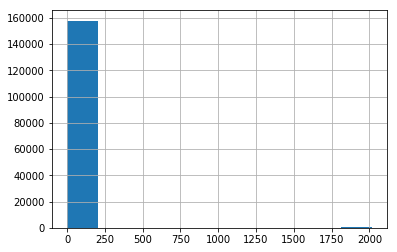

In [9]:
df_all["age"].hist()

Outliers are present (detected at 1750 and above)

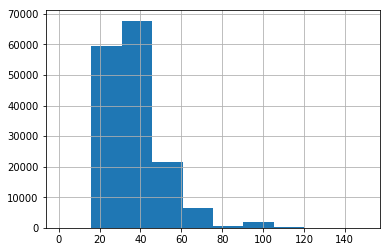

In [10]:
df_all[df_all["age"] < 250]["age"].hist()

Outliers are present (detected between 90 and 120)

Lets assume legitimate ages to be between 15 and 90. We can remove the rest of the entries.

In [11]:
df_all["age"].values

array([nan, 38., 56., ..., nan, nan, 49.])

In [12]:
# Remove outliers function (replaces with -1)
def remove_outliers(df, column, min_val, max_val):
    
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<min_val, col_values>max_val), np.NaN, col_values)
    return df

df_all = remove_outliers(df_all, 'age', 15, 90)
df_all['age'].fillna(-1, inplace=True)

C:\Users\Aakash\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\Aakash\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


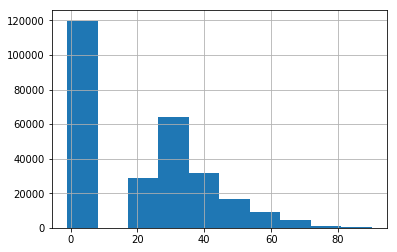

In [13]:
df_all["age"].hist()

### Filling missing values in columns

In [14]:
df_all['date_account_created'].fillna(df_all.timestamp_first_active, inplace=True)
df_all['first_affiliate_tracked'].fillna(-1, inplace=True)

## Transforming Categorical Data

One-hot encoding

In [15]:
# Home made One Hot Encoding function
def convert_to_binary(df, column_to_convert):
    categories = df[column_to_convert].drop_duplicates()
    
    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert[:7] + '_' + cat_name[:10]
        df[col_name] = 0
        df.loc[(df[column_to_convert] == category), col_name] = 1
        return df
    
columns_to_convert = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

for col in columns_to_convert:
    df_all = convert_to_binary(df_all, col)
    df_all.drop(col, axis=1, inplace=True)
     
        

## Adding related date fields

In [16]:
# Add new date related fields
df_all['day_account_created'] = df_all['date_account_created'].dt.weekday
df_all['month_account_created'] = df_all['date_account_created'].dt.month
df_all['quarter_account_created'] = df_all['date_account_created'].dt.quarter
df_all['year_account_created'] = df_all['date_account_created'].dt.year
df_all['hour_first_active'] = df_all['timestamp_first_active'].dt.hour
df_all['day_first_active'] = df_all['timestamp_first_active'].dt.weekday
df_all['month_first_active'] = df_all['timestamp_first_active'].dt.month
df_all['quarter_first_active'] = df_all['timestamp_first_active'].dt.quarter
df_all['year_first_active'] = df_all['timestamp_first_active'].dt.year
df_all['created_less_active'] = (df_all['date_account_created'] - df_all['timestamp_first_active']).dt.days

# Drop unnecessary columns
columns_to_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination']
for column in columns_to_drop:
    if column in df_all.columns:
        df_all.drop(column, axis=1, inplace=True)

# Sessions Data

## Determing Primary and Secondary Device

In [17]:
# Determine primary device

sessions_device = sessions.loc[:, ['user_id', 'device_type', 'secs_elapsed']]
aggregated_lvl1 = sessions_device.groupby(['user_id', 'device_type'], as_index=False, sort=False).aggregate(np.sum)
idx = aggregated_lvl1.groupby(['user_id'], sort=False)['secs_elapsed'].transform(max) == aggregated_lvl1['secs_elapsed']
df_primary = pd.DataFrame(aggregated_lvl1.loc[idx , ['user_id', 'device_type', 'secs_elapsed']])
df_primary.rename(columns = {'device_type':'primary_device', 'secs_elapsed':'primary_secs'}, inplace=True)
df_primary = convert_to_binary(df=df_primary, column_to_convert='primary_device')
df_primary.drop('primary_device', axis=1, inplace=True)

# Determine Secondary device

remaining = aggregated_lvl1.drop(aggregated_lvl1.index[idx])
idx = remaining.groupby(['user_id'], sort=False)['secs_elapsed'].transform(max) == remaining['secs_elapsed']
df_secondary = pd.DataFrame(remaining.loc[idx , ['user_id', 'device_type', 'secs_elapsed']])
df_secondary.rename(columns = {'device_type':'secondary_device', 'secs_elapsed':'secondary_secs'}, inplace=True)
df_secondary = convert_to_binary(df=df_secondary, column_to_convert='secondary_device')
df_secondary.drop('secondary_device', axis=1, inplace=True)

In [18]:
# Count occurrences of value in a column

def convert_to_counts(df, id_col, column_to_convert):
    id_list = df[id_col].drop_duplicates()

    df_counts = df.loc[:,[id_col, column_to_convert]]
    df_counts['count'] = 1
    df_counts = df_counts.groupby(by=[id_col, column_to_convert], as_index=False, sort=False).sum()

    new_df = df_counts.pivot(index=id_col, columns=column_to_convert, values='count')
    new_df = new_df.fillna(0)

    # Rename Columns
    categories = list(df[column_to_convert].drop_duplicates())
    
    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert + '_' + cat_name
        new_df.rename(columns = {category:col_name}, inplace=True)

    return new_df

# Aggregate and combine actions taken columns

session_actions = sessions.loc[:,['user_id', 'action', 'action_type', 'action_detail']]
columns_to_convert = ['action', 'action_type', 'action_detail']
session_actions = session_actions.fillna('not provided')
first = True

for column in columns_to_convert:
    print("Converting " + column + " column...")
    current_data = convert_to_counts(df=session_actions, id_col='user_id', column_to_convert=column)

    # If first loop, current data becomes existing data, otherwise merge existing and current
    if first:
        first = False
        actions_data = current_data
    else:
        actions_data = pd.concat([actions_data, current_data], axis=1, join='inner')

Converting action column...
Converting action_type column...
Converting action_detail column...


In [19]:
# Merge device datasets
print("Combining results...")
df_primary.set_index('user_id', inplace=True)
df_secondary.set_index('user_id', inplace=True)
device_data = pd.concat([df_primary, df_secondary], axis=1, join="outer")

# Merge device and actions datasets
combined_results = pd.concat([device_data, actions_data], axis=1, join='outer')
df_sessions = combined_results.fillna(0)

# Merge user and session datasets
df_all.set_index('id', inplace=True)
df_all = pd.concat([df_all, df_sessions], axis=1, join='inner')

Combining results...


In [20]:
# Prepare training data for modelling
train_df.set_index('id', inplace=True)
train_df = pd.concat([train_df['country_destination'], df_all], axis=1, join='inner')

id_train = train_df.index.values
labels = train_df['country_destination']
le = LabelEncoder()
y = le.fit_transform(labels)
X = train_df.drop('country_destination', axis=1, inplace=False)

In [22]:
# Grid Search - Used to find best combination of parameters
# XGB_model = xgb.XGBClassifier(objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)

# param_grid = {'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.3], 'n_estimators': [25, 50]}
# model = GridSearchCV(estimator=XGB_model, param_grid=param_grid, scoring='accuracy', verbose=10, n_jobs=1, iid=True, refit=True, cv=3)

# model.fit(X, y)
# print("Best score: %0.3f" % model.best_score_)
# print("Best parameters set:")
# best_parameters = model.best_estimator_.get_params()
# for param_name in sorted(param_grid.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [23]:
# After performing grid search, we havwe found best estimator
XGB_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=5, objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)
XGB_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5)

In [25]:
# preserve classifier
with open("XGB_model_airbnb.pickle", "wb") as f:
    pickle.dump(XGB_model, f)

## Making Predictions

In [26]:
# Prepare test data for prediction
test_df.set_index('id', inplace=True)
test_df = pd.merge(test_df.loc[:,['date_first_booking']], df_all, how='left', left_index=True, right_index=True, sort=False)
X_test = test_df.drop('date_first_booking', axis=1, inplace=False)
X_test = X_test.fillna(-1)
id_test = test_df.index.values

# Make predictions
y_pred = XGB_model.predict_proba(X_test)

In [32]:
y_pred[:5]

array([[0.0048175 , 0.00652964, 0.00568098, 0.00880468, 0.01150291,
        0.0075792 , 0.00912853, 0.76592964, 0.00554634, 0.00425472,
        0.14208001, 0.02814585],
       [0.00372848, 0.00365626, 0.00319032, 0.00461845, 0.00647952,
        0.00460181, 0.0060686 , 0.91211843, 0.00336316, 0.00351836,
        0.03719433, 0.0114623 ],
       [0.00325625, 0.00450484, 0.00351875, 0.00527044, 0.00826822,
        0.00552076, 0.00731496, 0.8973517 , 0.00365178, 0.00292503,
        0.04567942, 0.0127378 ],
       [0.00354692, 0.00491386, 0.00382664, 0.00567205, 0.00861223,
        0.00592821, 0.00824222, 0.8856793 , 0.00400461, 0.00318096,
        0.05133322, 0.01505978],
       [0.00786741, 0.01777932, 0.00809476, 0.01882391, 0.04213335,
        0.02391361, 0.03237706, 0.19874224, 0.01284322, 0.01090647,
        0.53852206, 0.08799658]], dtype=float32)

In [33]:
# Taking the 5 classes with highest probabilities
ids = [] # list of ids
cts = [] # list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()
 
